<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод:</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**ЗАГРУЗИМ БИБЛИОТЕКИ:**

In [1]:
import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set()

## Подготовка

In [3]:
# Загрузим и ознакомимся с данными
taxi_orders = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
display(taxi_orders.head())
taxi_orders.shape

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


(26496, 1)

In [4]:
# посмотрим на наличие пропусков
taxi_orders['num_orders'].isna().sum()

0

In [5]:
# провреим на монотонность
taxi_orders.index.is_monotonic

True

In [6]:
# выполнм ресемплирование по одному часу
taxi_orders = taxi_orders.resample('1H').sum()
taxi_orders.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**ВЫВОД:**  
Мы загрузили и проверили данные на монотонность. Провели ресэмплирование.

## Анализ

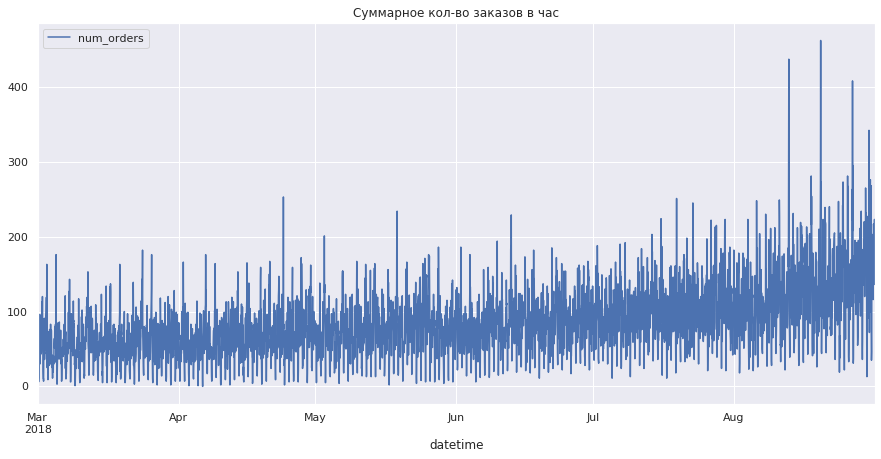

In [7]:
taxi_orders.plot(figsize=(15,7))
plt.title('Суммарное кол-во заказов в час');


Похоже на возрастающий тренд. Посмотрим на скользящюю среднюю

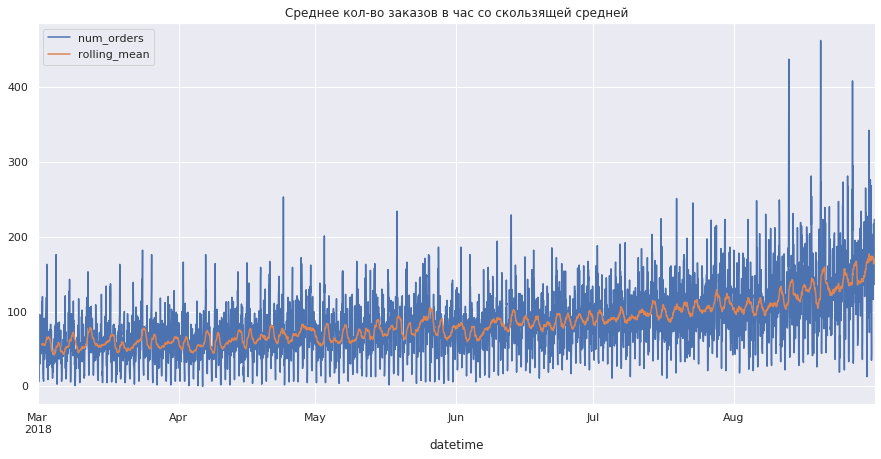

In [8]:
taxi_orders['rolling_mean'] = taxi_orders.rolling(24).mean()

taxi_orders.plot(figsize=(15,7))
plt.title('Среднее кол-во заказов в час со скользящей средней');

Скользящая средняя подтверждает тренд на рост числа заказов такси со временем

In [9]:
#воспользуемся модулем tsa для дальнейшего анализа
taxi_orders.drop('rolling_mean', axis=1, inplace=True)
decomposed = seasonal_decompose(taxi_orders)

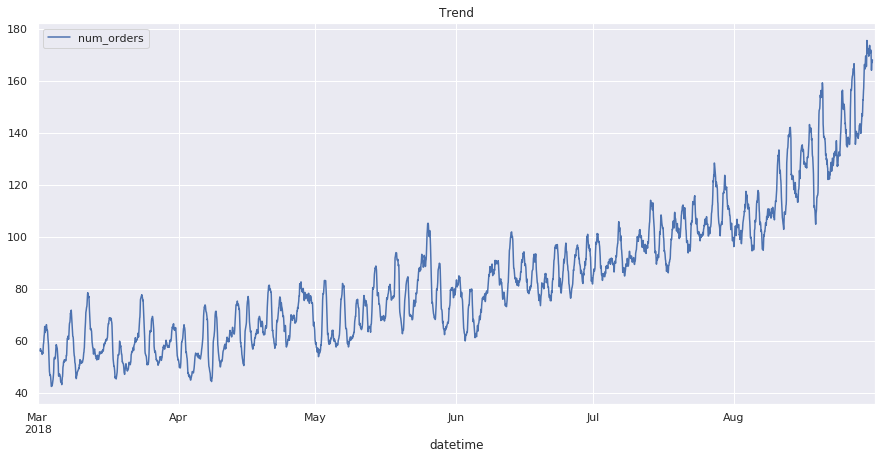

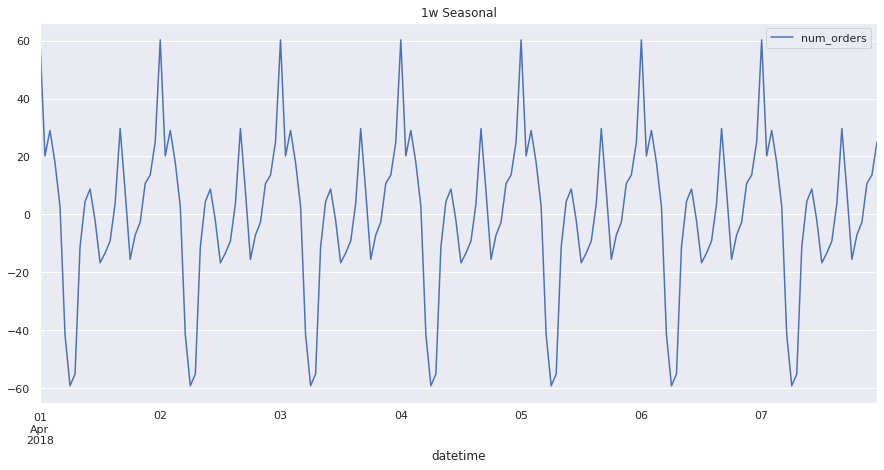

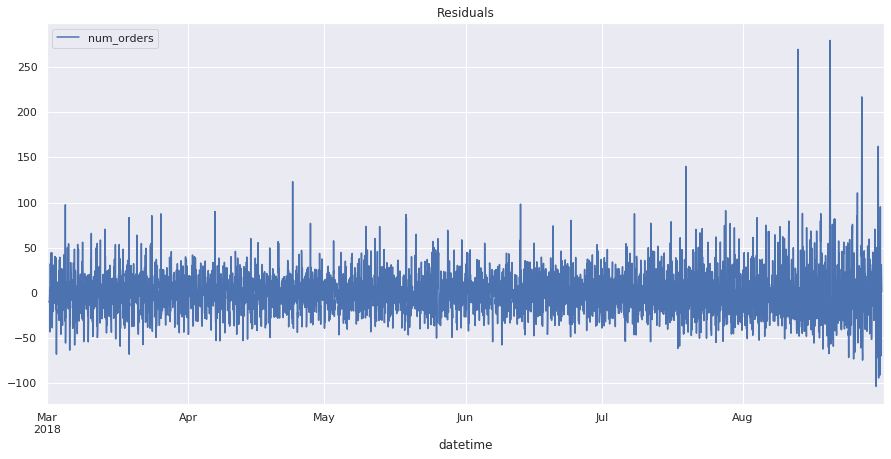

In [10]:
decomposed.trend.plot(figsize=(15,7))
plt.title('Trend');


decomposed.seasonal['2018-04-01':'2018-04-07'].plot(figsize=(15,7))
plt.title('1w Seasonal');


decomposed.resid.plot(figsize=(15,7))
plt.title('Residuals');

Очень красиво, но ничего не понятно :) кроме тренда

Оценим стационарность времянного ряда

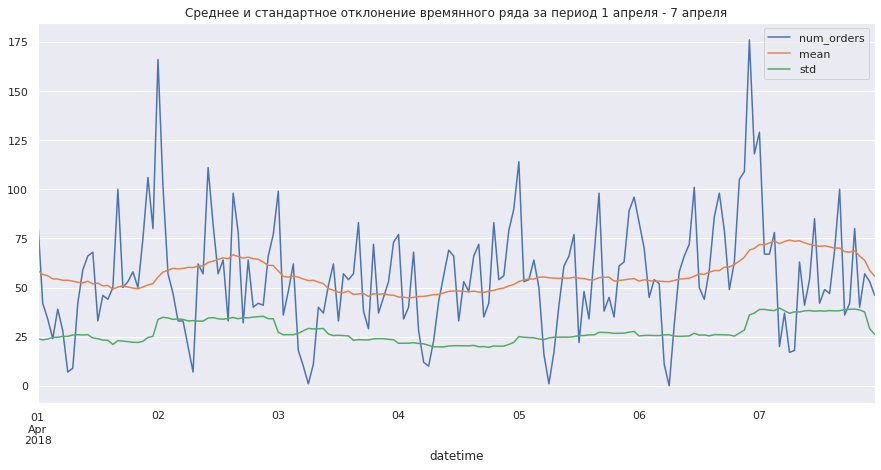

In [11]:
time_diff = taxi_orders.copy()

time_diff['mean'] = time_diff['num_orders'].rolling(24).mean()
time_diff['std'] = time_diff['num_orders'].rolling(24).std()


time_diff['2018-04-01':'2018-04-07'].plot(figsize=(15,7))
plt.title('Среднее и стандартное отклонение времянного ряда за период 1 апреля - 7 апреля');

Стандартное отклонение и среднее меняются - времянной ряд не стационарен.  Попробуем увеличить стационарность на следующем шаге

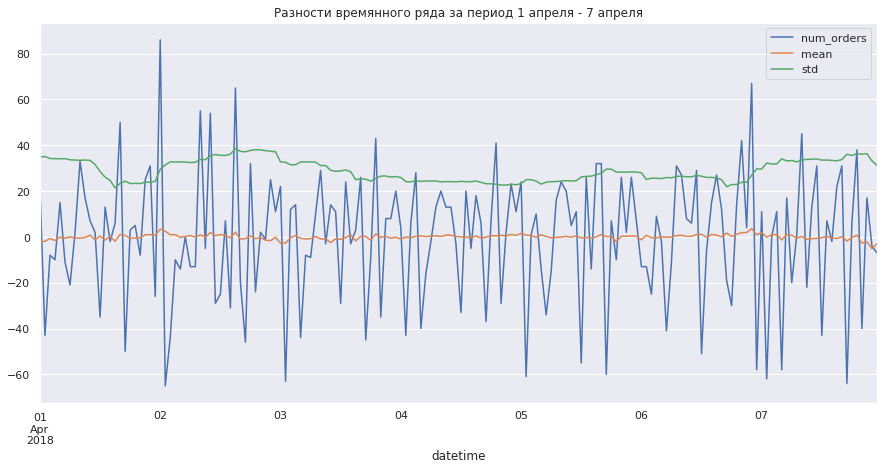

In [12]:
taxi_orders -= taxi_orders.shift()
taxi_orders['mean'] = taxi_orders['num_orders'].rolling(24).mean()
taxi_orders['std'] = taxi_orders['num_orders'].rolling(24).std()


taxi_orders['2018-04-01':'2018-04-07'].plot(figsize=(15,7))
plt.title('Разности времянного ряда за период 1 апреля - 7 апреля');

In [13]:
taxi_orders.drop(columns=['mean','std'], inplace=True)

Мы значительно улучшили стационарность времянного ряда, что должно улучшить наши результаты на предсказании

**ВЫВОД:**  
Мы проанализировали времянной ряд - посмотрели на скользящую среднюю, тренды и т.д. Оценили стационарность и улучшили её через разность времянных рядов.

## Обучение

Подготовим функции для разделения на выборки и обогащения признаками:

In [14]:
def splitter(data):
    train, test = train_test_split(data, shuffle=False, test_size=0.1)
    train = train.dropna()
     
    target_train = train['num_orders']
    features_train = train.drop('num_orders', axis=1)
    target_test = test['num_orders']
    features_test = test.drop('num_orders', axis=1)
 
    return target_train, features_train, target_test, features_test

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
 
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
 
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return splitter(data)

подготовим скоррер для кросс валидации:

In [16]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)

начнём обучение с линейной регрессии. Через функцию make_features попробуем подобрать оптимальный набор признаков

In [17]:
%%time
best_result = np.inf
for lag in range(1,2,1):
    for r_size in range(1,11,1):
    
        target_train, features_train, target_test, features_test = make_features(taxi_orders, lag, r_size)
        
        model = LinearRegression()
        score = -cross_val_score(model, features_train, target_train, scoring=scorer, cv=5).mean()
        if score < best_result:
            print(f"Параметры набора признаков: lag={lag}, r_size={r_size}")
            print("RMSE обучающей выборки:", score**0.5)
            best_result = score

Параметры набора признаков: lag=1, r_size=1
RMSE обучающей выборки: 34.23110539594099
Параметры набора признаков: lag=1, r_size=2
RMSE обучающей выборки: 33.91532525302748
Параметры набора признаков: lag=1, r_size=3
RMSE обучающей выборки: 33.59966762593347
Параметры набора признаков: lag=1, r_size=4
RMSE обучающей выборки: 33.170916494429605
Параметры набора признаков: lag=1, r_size=5
RMSE обучающей выборки: 33.038061796651945
Параметры набора признаков: lag=1, r_size=6
RMSE обучающей выборки: 32.344165823791705
Параметры набора признаков: lag=1, r_size=7
RMSE обучающей выборки: 32.293330799191736
Параметры набора признаков: lag=1, r_size=10
RMSE обучающей выборки: 32.084415121754006
CPU times: user 352 ms, sys: 3.96 ms, total: 356 ms
Wall time: 367 ms


И уже с моделью линейной регрессии получаем неплохой результат на кроссвалидации

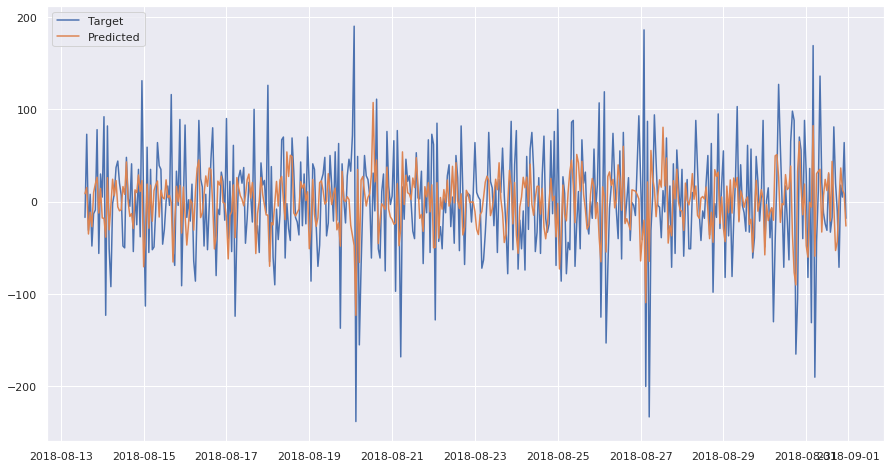

In [18]:
target_train, features_train, target_test, features_test = make_features(taxi_orders, 1, 10)
model = LinearRegression()
model.fit(features_train, target_train)
predict = model.predict(features_test)


# График факт/предсказанное
plt.figure(figsize=(15, 8))
plt.plot(target_test, label='Target')
plt.plot(target_test.index, predict, label='Predicted')
plt.legend()
plt.show()

In [19]:
predict

array([ 8.61049966e+00,  1.53968906e+01, -3.49790343e+01, -1.13631390e+01,
       -2.69716346e+01,  9.91331187e+00,  1.93038261e+01,  2.64574079e+01,
       -1.22652827e+01,  1.43465834e+01, -1.76229955e+01, -1.79808093e+01,
       -3.83828582e+01,  2.59924079e+01, -3.05353027e+01, -4.36735196e+00,
        2.43106418e+01,  6.44740502e+00,  2.28793657e+01, -5.65062895e+00,
       -9.89224416e+00, -8.62967559e+00,  1.63919547e+01,  7.93451177e+00,
        4.30392317e+01, -5.04528570e-02, -1.59713362e+01, -1.28522693e+01,
       -2.89878000e+01,  1.28240574e+01,  9.92926137e+00,  2.89045995e+01,
        1.11989243e+01,  2.28597057e+01, -7.04683781e+01, -3.26165939e+01,
        1.90641586e+01, -2.87492029e+01,  1.78845244e+01, -2.11377634e+01,
        1.19620275e+01,  1.82693385e+01,  2.24159889e+01, -1.66149768e+01,
        1.24434510e+01,  4.56967632e+00,  3.00936158e+00,  2.36726759e+01,
        4.57633896e+00,  6.73313344e+00, -1.07716013e+00, -6.52866185e+01,
       -2.11455783e+01,  

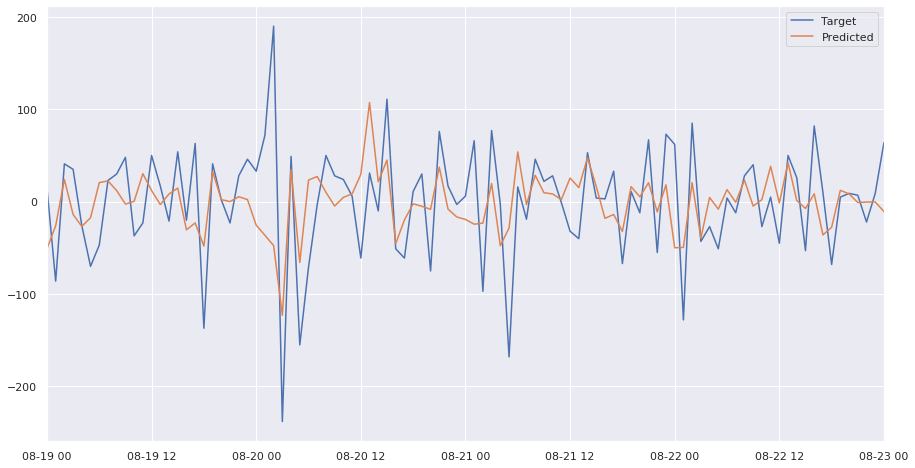

In [20]:
# График факт/предсказанное на отрезке
plt.figure(figsize=(15, 8))
plt.plot(target_test, label='Target')
plt.plot(target_test.index, predict, label='Predicted')
plt.xlim('2018-08-19','2018-08-23')
plt.legend()
plt.show()

Похоже что линейная регрессия сосредоточила предсказания ближе к центру, ей сложно даются выбросы и похоже сложнее всего выбросы в + сторону

Попробуем случайны лес:

In [21]:
%%time
best_result = np.inf

for lag in range(1,2,1):
    for r_size in range(1,11,1):
        for depth in range(1,21,1):
            target_train, features_train, target_test, features_test = make_features(taxi_orders, lag, r_size)
            
            model = DecisionTreeRegressor(max_depth=depth, random_state=2021)
            score = -cross_val_score(model, features_train, target_train, scoring=scorer, cv=5).mean()
            if score < best_result:
                print(f"Параметры набора признаков: lag={lag}, r_size={r_size}")
                print(f"Оценка модели при max_depth = {depth}:")
                print('RMSE обучающей выборки = ', score**0.5)
                best_result = score

Параметры набора признаков: lag=1, r_size=1
Оценка модели при max_depth = 1:
RMSE обучающей выборки =  34.939948152184634
Параметры набора признаков: lag=1, r_size=1
Оценка модели при max_depth = 2:
RMSE обучающей выборки =  34.01287741641261
Параметры набора признаков: lag=1, r_size=1
Оценка модели при max_depth = 3:
RMSE обучающей выборки =  32.210438115985646
Параметры набора признаков: lag=1, r_size=1
Оценка модели при max_depth = 4:
RMSE обучающей выборки =  31.50841208137299
Параметры набора признаков: lag=1, r_size=1
Оценка модели при max_depth = 5:
RMSE обучающей выборки =  30.29700546227441
Параметры набора признаков: lag=1, r_size=1
Оценка модели при max_depth = 6:
RMSE обучающей выборки =  29.771767244776854
Параметры набора признаков: lag=1, r_size=2
Оценка модели при max_depth = 5:
RMSE обучающей выборки =  29.506795849004263
Параметры набора признаков: lag=1, r_size=2
Оценка модели при max_depth = 6:
RMSE обучающей выборки =  29.011729529612815
Параметры набора признаков:

У более сложной модели немного лучший результат.

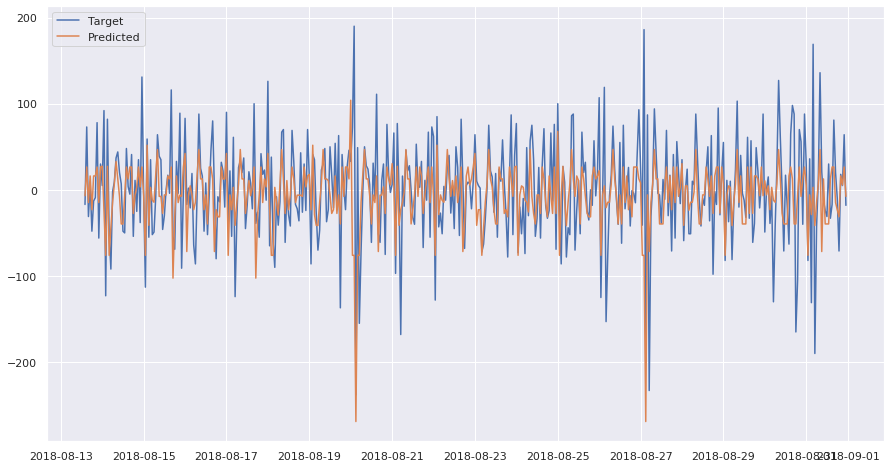

In [22]:
target_train, features_train, target_test, features_test = make_features(taxi_orders, 1, 5)
model = DecisionTreeRegressor(max_depth=6, random_state=2021)
model.fit(features_train, target_train)
predict = model.predict(features_test)


# График факт/предсказанное

plt.figure(figsize=(15, 8))
plt.plot(target_test, label='Target')
plt.plot(target_test.index, predict, label='Predicted')
plt.legend()
plt.show()

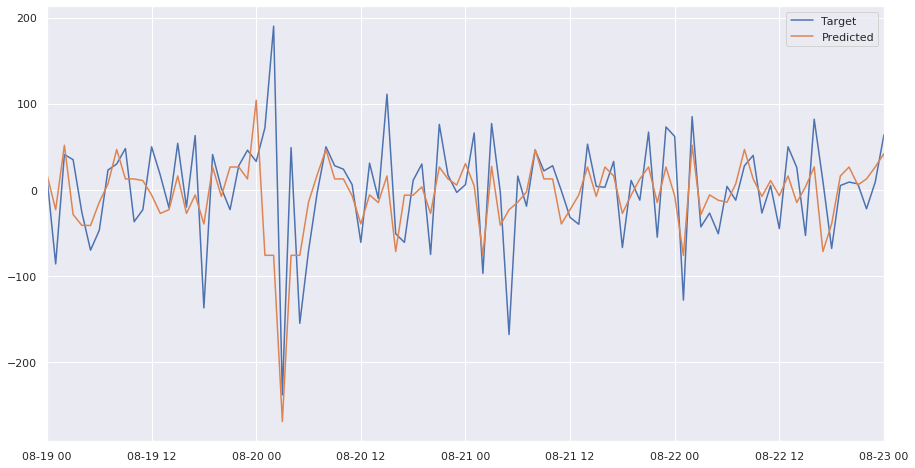

In [23]:
# График факт/предсказанное на отрезке
plt.figure(figsize=(15, 8))
plt.plot(target_test, label='Target')
plt.plot(target_test.index, predict, label='Predicted')
plt.xlim('2018-08-19','2018-08-23')
plt.legend()
plt.show()

Случайный лес уже лучше реагирует на выбросы, особенно в сторону '-', но точность как будто начала снижаться ближе к концу временного интервала.

In [24]:
%%time

best_result = np.inf

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 29,
    'num_iterations': 100,
    'n_estimators' : 100}

for lag in range(1,2,1):
    for r_size in range(1,11,1):
        target_train, features_train, target_test, features_test = make_features(taxi_orders, lag, r_size)
        model = lgb.LGBMRegressor(**params, random_state=2021)
        score = -cross_val_score(model, features_train, target_train, scoring=scorer, cv=5).mean()
        if score < best_result:
                print(f"Параметры набора признаков: lag={lag}, r_size={r_size}")
                print('RMSE обучающей выборки = ', score**0.5)
                best_result = score
        

Параметры набора признаков: lag=1, r_size=1
RMSE обучающей выборки =  28.481307873602514
Параметры набора признаков: lag=1, r_size=2
RMSE обучающей выборки =  26.752846755480643
Параметры набора признаков: lag=1, r_size=3
RMSE обучающей выборки =  26.645638744212654
Параметры набора признаков: lag=1, r_size=6
RMSE обучающей выборки =  26.495608507135305
Параметры набора признаков: lag=1, r_size=10
RMSE обучающей выборки =  26.17245836389157
CPU times: user 1min 34s, sys: 1.03 s, total: 1min 35s
Wall time: 1min 37s


В итоге самый лучший результат у градиентного бустинга, но прирост не намного больше линейной регрессии, хотя время  обучения значительно больше

**ВЫВОД:**  
По итогам, наилучший результат по метрике RMSE удалось получить градиентным бустингом, но времени на это ушло больше всего.

## Тестирование

In [28]:
%%time
target_train, features_train, target_test, features_test = make_features(taxi_orders, 1, 10)
        
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 29,
    'num_iterations': 1000,
    'n_estimators' : 100}

gbm = lgb.LGBMRegressor(**params, random_state=2021)

gbm.fit(features_train, target_train,
        eval_set=[(features_test, target_test)],
        eval_metric='rmse',
       verbose=100)

[100]	valid_0's rmse: 46.0365
[200]	valid_0's rmse: 46.088
[300]	valid_0's rmse: 46.2057
[400]	valid_0's rmse: 46.3691
[500]	valid_0's rmse: 46.3883
[600]	valid_0's rmse: 46.5291
[700]	valid_0's rmse: 46.5714
[800]	valid_0's rmse: 46.7562
[900]	valid_0's rmse: 46.7659
[1000]	valid_0's rmse: 46.8892
CPU times: user 9.61 s, sys: 198 ms, total: 9.81 s
Wall time: 9.97 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1,
              num_iterations=1000, num_leaves=29, objective='regression',
              random_state=2021, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

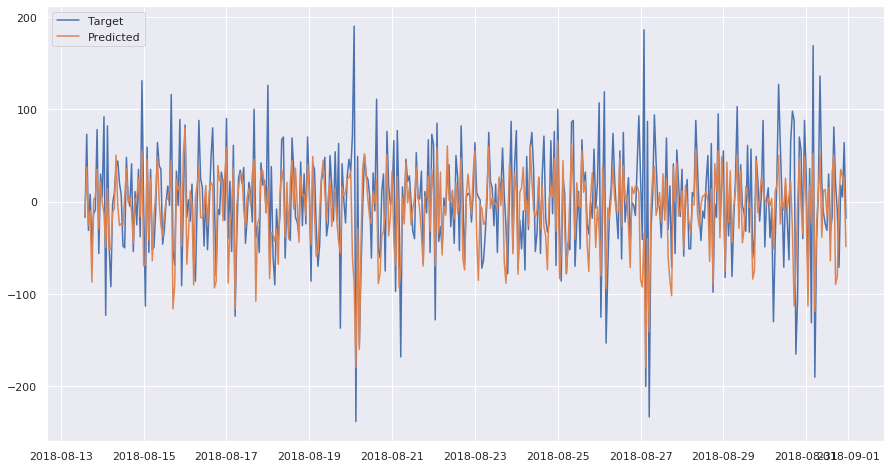

In [29]:
target_train, features_train, target_test, features_test = make_features(taxi_orders, 1, 10)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 29,
    'num_iterations': 1000,
    'n_estimators' : 100}

model = lgb.LGBMRegressor(**params, random_state=2021)

model.fit(features_train, target_train)
predict = model.predict(features_test)


# График факт/предсказанное

plt.figure(figsize=(15, 8))
plt.plot(target_test, label='Target')
plt.plot(target_test.index, predict, label='Predicted')
plt.legend()
plt.show()


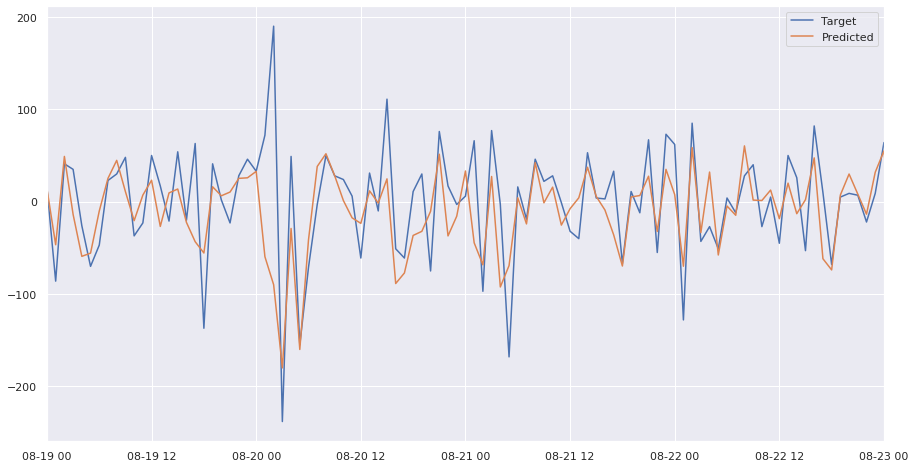

In [30]:
# График факт/предсказанное на отрезке
plt.figure(figsize=(15, 8))
plt.plot(target_test, label='Target')
plt.plot(target_test.index, predict, label='Predicted')
plt.xlim('2018-08-19','2018-08-23')
plt.legend()
plt.show()

модель lgbm выглядит на графике как что-то среднее между линейной регрессией и деревом решений) Модель работатет точнее ближе к концу времянного интервала, но хуже точность по центру, где был хороший результат у дерева решений

## Вывод:

1) Мы загрузили и обработали данные  
2) Проанализировали времянные ряды и повысили стационарность  
3) Обучили и протестировали модель  
4) Оценили графически точность предсказания моделей

В итоге наилучший результат по мтерике RMSE получили у модели lgbm, но графически наблюдаем очень неплохой результат у дерева решений.